In [1]:
import numpy as np
import scipy
from numba import jit
import imageio as iio
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
filename = 'malaga_title.png'
img = iio.imread(filename)

/tmp/ipykernel_24607/3199872483.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread(filename)


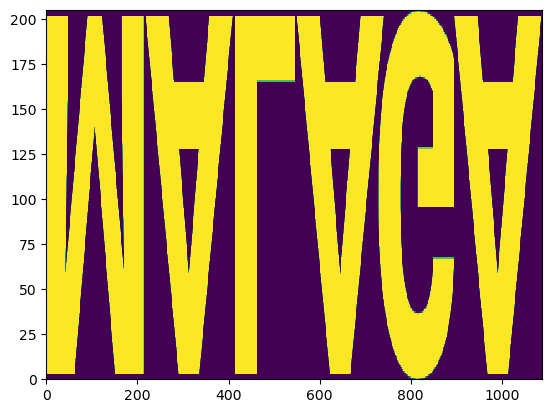

In [3]:
img_reduce = 1-img[:,:,0]/255
plt.pcolor(img_reduce)

In [14]:
@jit(nopython=True)
def sample_img(img, alpha=1):
    output = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.random.rand()<img[i,j]*alpha:
                output.append((j,i))
    return np.array(output)

@jit(nopython=True)
def generate_edges_gaussian(X,sigma,alpha, return_expected=False):
    ret = []
    if return_expected:
        W = np.zeros((X.shape[0], X.shape[0]), dtype = np.float64)
    else:
        W = np.zeros((1,1), dtype = np.float64)
    for i in range(X.shape[0]):
        for j in range(i):
            vi, vj = X[i,:], X[j,:]
            wij = alpha*np.exp(-((vi-vj)**2).sum()/(2*sigma**2))
            if np.random.rand() < wij:
                ret.append((i,j))
            if return_expected:
                W[i,j] = wij
    W = W+W.T
    return ret, W

@jit(nopython=True)
def generate_edges_epsilon_graph(X,epsilon,alpha):
    ret = []
    for i in range(X.shape[0]):
        for j in range(i):
            vi, vj = X[i,:], X[j,:]
            if np.random.rand() < alpha*(((vi-vj)**2).sum()<epsilon**2):
                ret.append((i,j))
    return ret

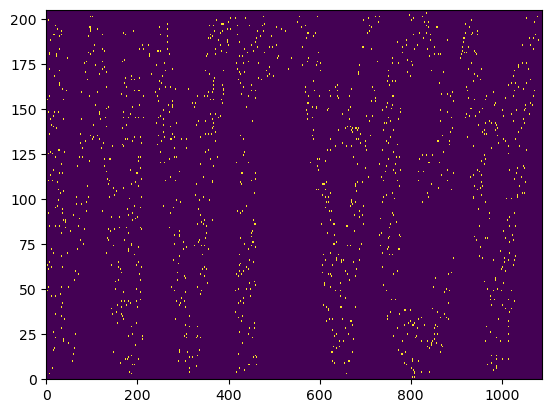

In [16]:
pos = sample_img(img_reduce, alpha=.025)
bin = np.zeros_like(img_reduce)
for (i,j) in pos:
    bin[j,i]=1
plt.pcolor(bin)

In [47]:
#edges = generate_edges_epsilon_graph(pos, epsilon=45, alpha=.05)
edges = generate_edges_gaussian(pos, sigma=25, alpha=.1)[0]
G=nx.Graph()
G.add_nodes_from(np.arange(len(pos)))
G.add_edges_from(edges)
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

poss = pos[[i for i in G0.nodes()]]
G0 = nx.convert_node_labels_to_integers(G0)

poss = (poss-pos.min())/(pos.max()-pos.min())
poss[:,1] = -poss[:,1]

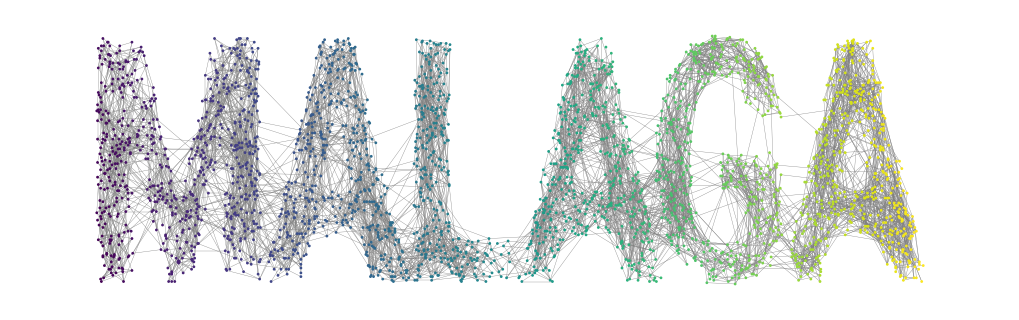

In [48]:
plt.figure(figsize=(10,3))
nx.draw(G0, node_size=1, node_color=poss[:,1]+5*poss[:,0], width=.25, edge_color='gray',pos=poss)
plt.savefig('malaga_title.pdf', bbox_inches='tight')

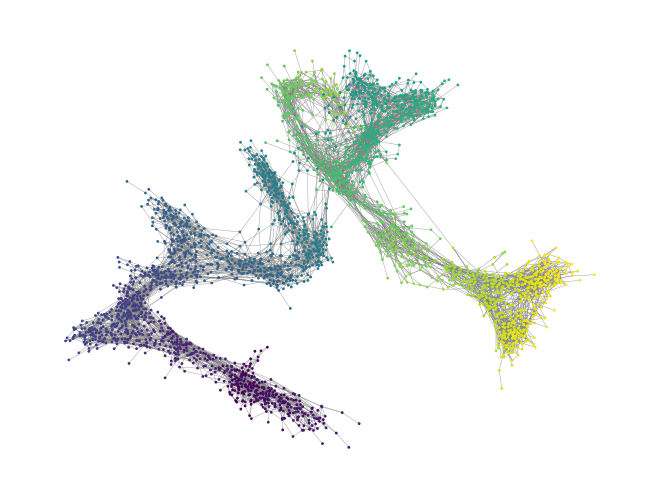

In [49]:
init_pos = nx.spring_layout(G0)
init_poss = np.array([init_pos[i] for i in G0.nodes()])
nx.draw(G0, node_size=1, node_color=poss[:,1]+5*poss[:,0], width=.25, edge_color='gray', pos = init_poss)

In [50]:
from scipy.spatial.transform import Rotation as R
rot = R.align_vectors(np.concatenate((poss, np.zeros((poss.shape[0],1))), axis=1),
                      np.concatenate((init_poss, np.zeros((init_poss.shape[0],1))), axis=1))
posss = rot[0].apply(np.concatenate((init_poss, np.zeros((init_poss.shape[0],1))), axis=1))[:,:2]

In [53]:
import gif
@gif.frame
def plot_malaga(i, lim=30):
    t = (i/(lim-1))**(1/2)
    figsize = t*np.array([2,10])+(1-t)*np.array([5,5])
    plt.figure(figsize=(10,3))
    nx.draw(G0, node_size=2, node_color=poss[:,1]+5*poss[:,0], width=.25, edge_color='gray',pos=t*poss+(1-t)*posss)

In [54]:
frames = [plot_malaga(i, lim=100) for i in range(100)] + [plot_malaga(1, lim=2) for i in range(30)] #+ [plot_malaga(981 + i, lim=991) for i in range(10)] 
fframes = frames.copy()
fframes.reverse()
frames = frames + fframes

In [56]:
gif.save(frames, 'malaga.gif', duration=20)